In [118]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [119]:
# Load the inflation factor and forex data
interest_data = pd.read_csv('/Users/miaxiaozile/Downloads/$/forex-project/data/interest.csv', index_col='Unnamed: 0')
forex_data = pd.read_csv('/Users/miaxiaozile/Downloads/$/forex-project/data/fx_yoy.csv', index_col='Unnamed: 0')

# Convert index to timestamp if necessary
interest_data.index = pd.to_datetime(interest_data.index).to_period('M')
forex_data.index = pd.to_datetime(forex_data.index).to_period('M')

# Merge the data on their index
data = pd.merge(interest_data, forex_data, left_index=True, right_index=True)

# Convert merged data index back to Timestamp
data.index = data.index.to_timestamp()

In [120]:
data

,interest,USD/CNY Central Parity Rate
2010-01-01,-2.909512,-0.160866
2010-02-01,-2.752332,-0.160868
2010-03-01,-2.791041,-0.140435
2010-04-01,-2.675183,0.019048
2010-05-01,-2.554803,-0.064399
...,...,...
2024-02-01,3.229167,2.182137
2024-03-01,3.260625,3.249560
2024-04-01,3.313275,2.632871
2024-05-01,3.341978,0.377007


In [121]:
# Ensure data is stationary
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Statistic for {name}: {result[0]}')
    print(f'p-value for {name}: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Values {key}: {value}')

# Initial ADF test
adf_test(data['interest'], 'Interest')
adf_test(data['USD/CNY Central Parity Rate'], 'USD/CNY Central Parity Rate')

# Differencing the inflation series to make it stationary
data['interest_diff'] = data['interest'].diff()

# Remove any NaN values created by differencing
data = data.dropna(subset=['interest_diff'])

# Check for any remaining NaN values
print(data.isnull().sum())

# Re-run ADF test on the differenced inflation series
adf_test(data['interest_diff'], 'Interest Differenced')

ADF Statistic for Interest: -0.29342681190905245
p-value for Interest: 0.9264301468300097
Critical Values 1%: -3.469413468959902
Critical Values 5%: -2.8786964197028295
Critical Values 10%: -2.5759166089965397
ADF Statistic for USD/CNY Central Parity Rate: -2.9671768801717007
p-value for USD/CNY Central Parity Rate: 0.03807545103485297
Critical Values 1%: -3.4718957209472654
Critical Values 5%: -2.8797795410156253
Critical Values 10%: -2.5764947265625
interest                       0
USD/CNY Central Parity Rate    0
interest_diff                  0
dtype: int64
ADF Statistic for Interest Differenced: -4.3662448040795985
p-value for Interest Differenced: 0.00034043549868326226
Critical Values 1%: -3.469413468959902
Critical Values 5%: -2.8786964197028295
Critical Values 10%: -2.5759166089965397


In [122]:
# Normalize the data
scaler = StandardScaler()
data_diff_scaled = pd.DataFrame(scaler.fit_transform(data[['interest_diff', 'USD/CNY Central Parity Rate']]), index=data.index, columns=['interest_diff', 'USD/CNY Central Parity Rate'])

In [123]:
# Define time series split
tscv = TimeSeriesSplit(n_splits=5)
best_mse = float('inf')
best_lag = 0

# Hyperparameter tuning for lag order using cross-validation
for lag in range(1, 16):
    mse_list = []
    for train_index, test_index in tscv.split(data_diff_scaled):
        train, test = data_diff_scaled.iloc[train_index], data_diff_scaled.iloc[test_index]
        model = VAR(train)
        result = model.fit(lag)
        forecast = result.forecast(train.values[-lag:], steps=len(test))
        forecast_df = pd.DataFrame(forecast, index=test.index, columns=train.columns)
        mse = mean_squared_error(test['USD/CNY Central Parity Rate'], forecast_df['USD/CNY Central Parity Rate'])
        mse_list.append(mse)
    
    avg_mse = np.mean(mse_list)
    if avg_mse < best_mse:
        best_mse = avg_mse
        best_lag = lag

print(f'Best Lag Order based on Cross-Validation: {best_lag}, Best MSE: {best_mse}')

Best Lag Order based on Cross-Validation: 2, Best MSE: 1.3606823148657214


In [124]:
best_lag = 6

In [125]:
# Split the data into training and testing sets
train_size = int(len(data_diff_scaled) * 0.8)
train_data = data_diff_scaled.iloc[:train_size]
test_data = data_diff_scaled.iloc[train_size:]

# Fit the VAR model with the best lag order and include a trend
model = VAR(train_data)
result = model.fit(best_lag, trend='ct')  # You can try 'ct' or 'ctt' for trend inclusion
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 14, Jul, 2024
Time:                     22:59:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.15959
Nobs:                     132.000    HQIC:                  -2.52260
Log likelihood:          -163.708    FPE:                  0.0626941
AIC:                     -2.77109    Det(Omega_mle):       0.0512470
--------------------------------------------------------------------
Results for equation interest_diff
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                 -0.260268         0.181050           -1.438           0.151
trend                                  0.002186         0.002138            1.023 

In [126]:
# Forecasting
forecast_steps = len(test_data)
forecast = result.forecast(train_data.values[-best_lag:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=train_data.columns)

# Inverse transform the forecast to the original scale
forecast_df = pd.DataFrame(scaler.inverse_transform(forecast_df), index=forecast_df.index, columns=forecast_df.columns)
test_data_original = pd.DataFrame(scaler.inverse_transform(test_data), index=test_data.index, columns=test_data.columns)

# Calculate the mean squared error for the forex rate
mse = mean_squared_error(test_data_original['USD/CNY Central Parity Rate'], forecast_df['USD/CNY Central Parity Rate'])
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 8.700051327981146


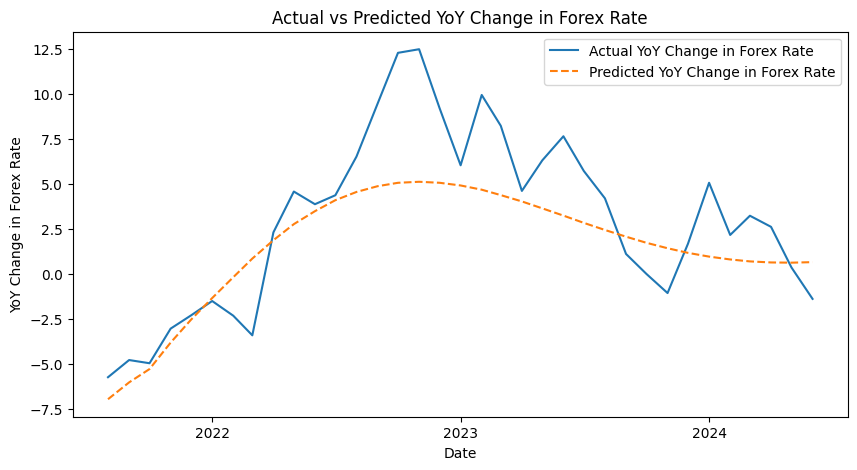

In [127]:
# Plot the actual vs predicted forex rates
plt.figure(figsize=(10, 5))
plt.plot(test_data_original.index, test_data_original['USD/CNY Central Parity Rate'], label='Actual YoY Change in Forex Rate')
plt.plot(forecast_df.index, forecast_df['USD/CNY Central Parity Rate'], label='Predicted YoY Change in Forex Rate', linestyle='--')

# Set major locator and formatter to display only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add legend, title, and labels
plt.legend()
plt.title('Actual vs Predicted YoY Change in Forex Rate')
plt.xlabel('Date')
plt.ylabel('YoY Change in Forex Rate')
plt.show()

In [128]:
# Convert forecast_df index to period for further processing
forecast_df.index = forecast_df.index.to_period('M')

# Load the actual data
actual_data = pd.read_csv('/Users/miaxiaozile/Downloads/$/forex-project/data/fx.csv').set_index('Unnamed: 0')
actual_data.index.name = "Date"
actual_data.index = pd.to_datetime(actual_data.index)
actual_data.index = actual_data.index.to_period('M')

# Determine the start of the forecast period
start_forecast_period = forecast_df.index.min()

# Ensure that the actual data includes the 12 months leading up to the forecast period
required_start_date = start_forecast_period - 12

# Filter the actual data to include the required period
extended_actual_data = actual_data.loc[required_start_date:]

# Ensure that the predicted YoY changes and the actual data overlap correctly
overlap_index = extended_actual_data.index.intersection(forecast_df.index)
aligned_actual = extended_actual_data.loc[overlap_index]
aligned_predicted_yoy = forecast_df.loc[overlap_index]

In [129]:
# Initialize the list with the first actual value (12 months prior to the forecast start)
predicted_actual_values = []

# Loop through the predicted YoY changes starting from the 12th month
for i in range(len(aligned_predicted_yoy)):
    prev_value = extended_actual_data['USD/CNY Central Parity Rate'].iloc[i]
    change = aligned_predicted_yoy['USD/CNY Central Parity Rate'].iloc[i]
    new_value = prev_value * (1 + change / 100)
    predicted_actual_values.append(new_value)

# Create a DataFrame for the predicted actual values
predicted_actual_df = pd.DataFrame(predicted_actual_values, index=aligned_predicted_yoy.index, columns=['Predicted USD/CNY Central Parity Rate'])

# Convert the period index back to a datetime index for plotting
aligned_actual.index = aligned_actual.index.to_timestamp()
predicted_actual_df.index = predicted_actual_df.index.to_timestamp()

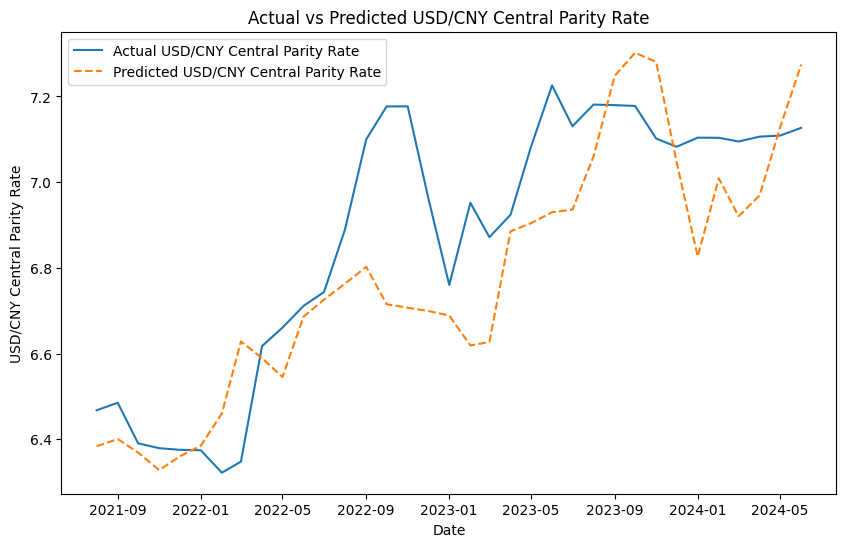

In [130]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(aligned_actual['USD/CNY Central Parity Rate'], label='Actual USD/CNY Central Parity Rate')
plt.plot(predicted_actual_df['Predicted USD/CNY Central Parity Rate'], label='Predicted USD/CNY Central Parity Rate', linestyle='--')
plt.title('Actual vs Predicted USD/CNY Central Parity Rate')
plt.xlabel('Date')
plt.ylabel('USD/CNY Central Parity Rate')
plt.legend()
plt.show()

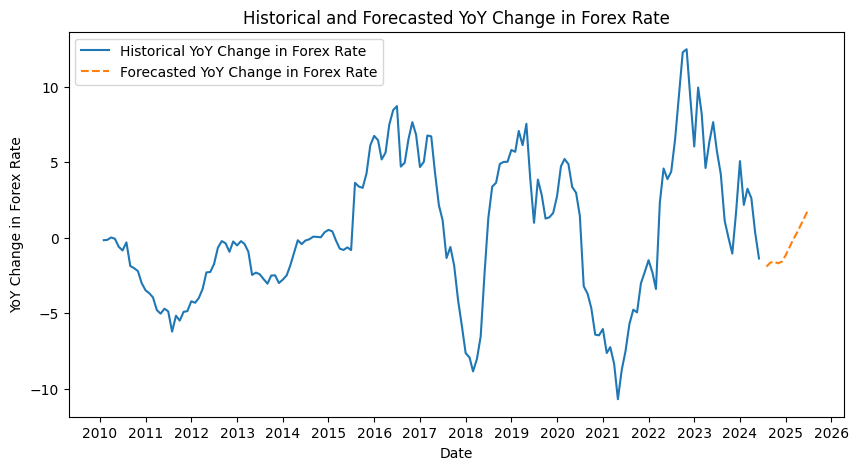

In [155]:
# Fit the VAR model with the best lag order on the entire dataset
model = VAR(data_diff_scaled)
result = model.fit(best_lag, trend='ct')

# Forecast future values (next 12 months)
future_forecast_steps = 12  # Number of months to forecast
future_forecast = result.forecast(data_diff_scaled.values[-best_lag:], steps=future_forecast_steps)
future_forecast_df = pd.DataFrame(future_forecast, index=pd.date_range(start=data.index[-1] + pd.offsets.MonthBegin(1), periods=future_forecast_steps, freq='M'), columns=data_diff_scaled.columns)

# Inverse transform the forecast to the original scale
future_forecast_df = pd.DataFrame(scaler.inverse_transform(future_forecast_df), index=future_forecast_df.index, columns=future_forecast_df.columns)

# Plot the forecasted forex rates
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['USD/CNY Central Parity Rate'], label='Historical YoY Change in Forex Rate')
plt.plot(future_forecast_df.index, future_forecast_df['USD/CNY Central Parity Rate'], label='Forecasted YoY Change in Forex Rate', linestyle='--')

# Set major locator and formatter to display only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add legend, title, and labels
plt.legend()
plt.title('Historical and Forecasted YoY Change in Forex Rate')
plt.xlabel('Date')
plt.ylabel('YoY Change in Forex Rate')
plt.show()

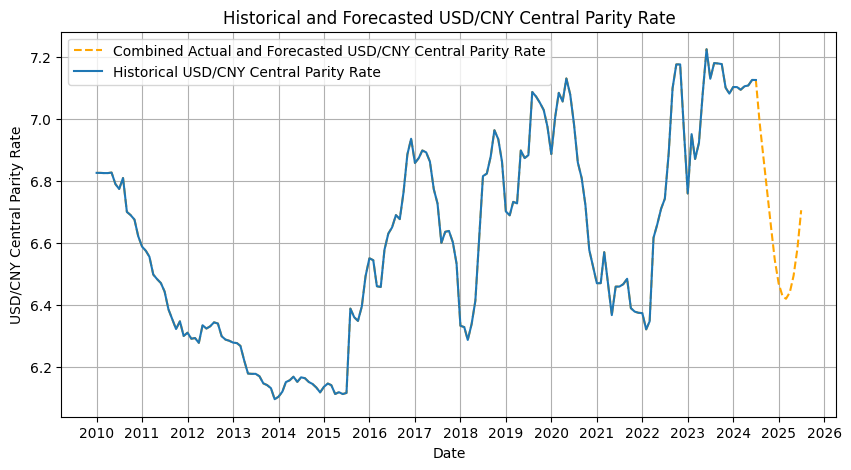

In [156]:
# Initialize the list with the last actual value from actual_data
last_actual_value = actual_data['USD/CNY Central Parity Rate'].iloc[-1]
forecasted_actual_values = [last_actual_value]

# Loop through the predicted YoY changes to calculate actual forecasted values
for i in range(len(future_forecast_df)):
    change = future_forecast_df['USD/CNY Central Parity Rate'].iloc[i]
    new_value = forecasted_actual_values[-1] * (1 + change / 100)
    forecasted_actual_values.append(new_value)

# Remove the first value as it is the last actual value
forecasted_actual_values = forecasted_actual_values[1:]

# Create a DataFrame for the forecasted actual values
forecasted_actual_df = pd.DataFrame(forecasted_actual_values, index=future_forecast_df.index, columns=['Forecasted USD/CNY Central Parity Rate'])

# Convert the index of actual_data to datetime if it's in period format
if isinstance(actual_data.index, pd.PeriodIndex):
    actual_data.index = actual_data.index.to_timestamp()

# Plot the historical actual values and the forecasted actual values
plt.figure(figsize=(10, 5))
# plt.plot(forecasted_actual_df.index, forecasted_actual_df['Forecasted USD/CNY Central Parity Rate'], label='Forecasted USD/CNY Central Parity Rate', linestyle='--')

# Combine the historical data and forecasted data to create a continuous line
combined_values = pd.concat([actual_data['USD/CNY Central Parity Rate'], forecasted_actual_df['Forecasted USD/CNY Central Parity Rate']])
plt.plot(combined_values.index, combined_values, linestyle='--', color='orange', label='Combined Actual and Forecasted USD/CNY Central Parity Rate')
plt.plot(actual_data.index, actual_data['USD/CNY Central Parity Rate'], label='Historical USD/CNY Central Parity Rate')


# Set major locator and formatter to display only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add legend, title, and labels
plt.legend()
plt.grid()
plt.title('Historical and Forecasted USD/CNY Central Parity Rate')
plt.xlabel('Date')
plt.ylabel('USD/CNY Central Parity Rate')
plt.show()

In [157]:
combined_values.to_csv("/Users/miaxiaozile/Downloads/$/forex-project/data/interest_pred.csv", header=True)